# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 5 - Clustering and Reinforcement Learning




**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import os
#uncomment for running on Jupyter Hub
# os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"  

# from rpy2.robjects.packages import importr
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#RL
import gym
from gym.envs.registration import register
import sys
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
#from tqdm import tqdm
from copy import deepcopy
import numpy.linalg as LA


import rpy2
from rpy2.robjects.packages import importr
import IPython
import rpy2
from rpy2.robjects.lib.grdevices import render_to_bytesio
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import rpy2.robjects.lib.ggplot2 as ggplot2
r_utils = importr('utils')
r_ggplot2 = importr('ggplot2')
r_stats = importr('stats')
r_factoextra = importr('factoextra')
r_base = importr('base')

# additional libraries I have used in this assignment
import collections
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%load_ext rpy2.ipython
%load_ext rmagic
from rpy2.robjects import pandas2ri
pandas2ri.activate()

C:\Users\svi1\AppData\Local\Continuum\anaconda3\envs\new109b\lib\site-packages\IPython\extensions\rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "



<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
Data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`


Start by reading the dataset into a pandas data frame.

In [8]:
#your code here
df = pd.read_csv('postures_clean.csv')
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,1,0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,...,-47.909511,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124
1,1,0,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,...,-25.243914,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553
2,1,0,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,...,-67.660208,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279
3,2,0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,-74.307346,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147
4,2,0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,-71.629823,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243


In [9]:
df.describe()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
count,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,...,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000,38943.000000
mean,3.533986,8.149501,51.392252,93.748418,-18.956761,48.644293,97.228337,-16.921813,46.432265,97.351512,...,-18.446645,45.392642,93.295433,-19.125065,45.201114,90.839851,-19.920157,44.463433,88.463343,-20.368719
std,1.332452,4.587195,34.070402,40.145995,34.976568,34.922596,38.076977,34.671422,36.395332,37.470755,...,35.597032,37.104094,39.746619,35.602273,37.556616,40.227409,34.827888,38.378395,40.503378,33.943957
min,1.000000,0.000000,-108.552738,-67.157904,-120.284665,-111.685241,-65.758453,-120.290858,-99.917453,-64.830342,...,-157.199089,-99.014815,-64.282645,-118.328399,-100.084275,-67.283707,-153.449813,-108.605639,-64.972157,-113.733105
25%,2.000000,5.000000,28.169252,74.946345,-43.598807,22.574182,79.747406,-41.210343,17.617698,81.302159,...,-45.169035,15.849890,76.376404,-46.363837,15.132050,68.915784,-46.547792,13.081363,63.541846,-45.676522
50%,4.000000,9.000000,54.596564,93.966079,-15.041397,52.960933,96.690641,-12.046916,51.184849,97.222693,...,-14.823751,50.160084,97.040377,-16.010237,49.968499,95.562441,-17.101080,49.601058,93.796334,-19.428819
75%,5.000000,12.000000,77.390834,130.932659,7.998678,75.560564,131.729311,9.065824,74.435194,130.794462,...,9.382799,73.761617,126.844621,9.031498,74.558859,123.069653,7.767866,75.721811,119.188963,6.591351
max,5.000000,14.000000,160.850926,169.175464,113.345119,158.783454,170.209350,104.697852,163.547310,168.186466,...,119.237203,180.563322,167.926171,110.898899,176.409004,168.598384,117.914907,189.221529,169.127359,117.815967


In [10]:
df.Class.unique(), df.User.unique()

(array([1, 2, 3, 4, 5]),
 array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [11]:
df.shape

(38943, 26)

<div class='exercise'><b> Problem 1: Clustering with k-means </b></div>

(a) After appropriate pre-processing run the k-means clustering algorithm, using the function `r_stats.kmeans`, with the number of clusters corresponding to the number of users, `n_start` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

In [12]:
new_df = df.drop(['Class', 'User'], axis=1)
new_df.columns

Index(['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3',
       'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7'],
      dtype='object')

In [13]:
scaled_df = pd.DataFrame(StandardScaler().fit_transform(new_df), 
                         columns = new_df.columns)

In [14]:
scaled_df.head()

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,0.625185,-1.089155,-1.544096,-1.724904,-0.420054,-0.332509,0.145563,-0.387161,-1.110460,1.096005,...,-0.827688,-0.953120,-0.108877,-0.362904,-0.997669,-1.633346,0.879868,0.299142,-1.702348,-1.473371
1,1.005453,-0.502856,-1.511933,-0.488208,-0.184115,-0.874647,0.159324,-0.400049,-1.119100,0.788380,...,-0.190953,-0.946407,-0.117935,-0.362691,0.295763,-1.791465,-1.466555,-0.978434,-1.567682,0.885774
2,-1.812131,-0.298840,-0.189590,-0.436096,-0.137679,-0.704988,-1.121234,-1.943625,0.716769,0.196395,...,-1.382536,1.121899,-0.447597,-1.357711,0.309035,-1.737368,-1.391307,-0.856256,0.023139,-0.256118
3,0.356992,0.118135,0.861236,0.014763,1.499676,1.411151,1.273830,1.061954,0.514683,0.951894,...,-1.569272,0.351144,-1.655402,-1.477116,-0.866454,0.105335,1.423722,1.033060,1.557473,1.097702
4,0.865324,-0.000645,0.399357,0.427460,0.032784,0.812343,0.074473,1.521087,1.402944,1.340765,...,-1.494053,-0.668910,0.996777,1.530099,1.271189,1.152039,0.609223,-0.234076,0.278392,1.271847


In [15]:
#your code here
r_base = importr('base')
r_base.set_seed(109) #set seed for random number generation to 109

r_stats = importr('stats')
#set n_start to 46 and set number of clusters to 14
# r_km_out = r_stats.kmeans(scaled_df.iloc[:, 2:26], centers=14, nstart=46)  
r_km_out = r_stats.kmeans(scaled_df, centers=14, nstart=46)  

display(r_km_out)
display(list(r_km_out.names))
# display(r_km_out.rx2("size"))

R object with classes: ('kmeans',) mapped to:
<ListVector - Python:0x7faa075d7a48 / R:0x561c543e1b28>
[IntVector, Matrix, FloatVector, FloatVector, ..., FloatVector, IntVector, IntVector, IntVector]
  cluster: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa075d7848 / R:0x561c56d58890>
[7, 7, 13, 14, ..., 11, 11, 11, 11]
  centers: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7faa075d7648 / R:0x561c544c0460>
[0.081509, -0.086356, -0.106401, -0.055932, ..., -0.186538, -0.705165, 0.042306, 0.425519]
  totss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa075d7288 / R:0x561c576e0880>
[934632.000000]
  withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa075d7188 / R:0x561c567b9b18>
[47323.225414, 32142.374808, 64122.961622, 48747.571400, ..., 52442.332661, 40952.260448, 38958.972870, 52733.522663]
  tot.withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa074d2688 / R:0x561c57c95158>
[647677.647563]
  betweenss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa074d20c8 / R:0x561c576e07d8>
[286954.352437]
  size: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa074d2648 / R:0x561c56c74278>
[2,716, 1,939, 4,305, 2,698, ..., 3,775, 3,014, 2,410, 2,870]
  iter: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa074d2d48 / R:0x561c57c95040>
[7]
  ifault: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa074d28c8 / R:0x561c57c94f60>
[0]

['cluster',
 'centers',
 'totss',
 'withinss',
 'tot.withinss',
 'betweenss',
 'size',
 'iter',
 'ifault']

In [16]:
# scaled_df['Cluster14'] = r_km_out.rx2("cluster")
scaled_df['Cluster14'] = r_km_out.rx2("cluster")

In [17]:
scaled_df.head()  #view first 5 rows after adding Cluster results to the dataset

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,Cluster14
0,0.625185,-1.089155,-1.544096,-1.724904,-0.420054,-0.332509,0.145563,-0.387161,-1.110460,1.096005,...,-0.953120,-0.108877,-0.362904,-0.997669,-1.633346,0.879868,0.299142,-1.702348,-1.473371,7
1,1.005453,-0.502856,-1.511933,-0.488208,-0.184115,-0.874647,0.159324,-0.400049,-1.119100,0.788380,...,-0.946407,-0.117935,-0.362691,0.295763,-1.791465,-1.466555,-0.978434,-1.567682,0.885774,7
2,-1.812131,-0.298840,-0.189590,-0.436096,-0.137679,-0.704988,-1.121234,-1.943625,0.716769,0.196395,...,1.121899,-0.447597,-1.357711,0.309035,-1.737368,-1.391307,-0.856256,0.023139,-0.256118,13
3,0.356992,0.118135,0.861236,0.014763,1.499676,1.411151,1.273830,1.061954,0.514683,0.951894,...,0.351144,-1.655402,-1.477116,-0.866454,0.105335,1.423722,1.033060,1.557473,1.097702,14
4,0.865324,-0.000645,0.399357,0.427460,0.032784,0.812343,0.074473,1.521087,1.402944,1.340765,...,-0.668910,0.996777,1.530099,1.271189,1.152039,0.609223,-0.234076,0.278392,1.271847,2


In [16]:
np.unique(scaled_df.Cluster14, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([2716, 1939, 4305, 2698, 2654, 2015, 2390, 2526, 2349, 3282, 3775,
        3014, 2410, 2870], dtype=int64))

In [17]:
np.unique(df.User, return_counts=True)

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int64),
 array([3641, 2381, 1917,   75, 3299, 2860,  150, 2746, 3262, 4389, 3777,
        1860, 3141, 5445], dtype=int64))

In [18]:
np.sort(scaled_df.Cluster14.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

(b) Now visualize the results for k-means on a random sample of 2,000 observations without replacement (setting 109 as the random seed when sampling), using the function `r_factoextra.fviz_cluster`. Does 14 clusters seem to make sense?

In [19]:
# convert pandas dataframe to r dataframe
# r_scaled_df = pandas2ri.py2ri(scaled_df.iloc[:, 2:27])
r_df = pandas2ri.py2ri(scaled_df)

In [20]:
r_df

X0,Y0,Z0,...,Y7,Z7,Cluster14
0.625185,-1.089155,-1.544096,...,-1.702348,-1.473371,7
1.005453,-0.502856,-1.511933,...,-1.567682,0.885774,7
-1.812131,-0.298840,-0.189590,...,0.023139,-0.256118,13
0.356992,0.118135,0.861236,...,1.557473,1.097702,14
...,...,...,...,...,...,...
0.086370,0.884419,-0.716476,...,0.321087,0.423744,11
0.080989,0.884809,-0.720964,...,-0.693792,-1.247661,11


In [21]:
%%R -i r_df
set.seed(109)
lst = sample(nrow(r_df), 2000, replace=FALSE) 
#Random sample of 2000 observations without replacement and with random_seed=109 

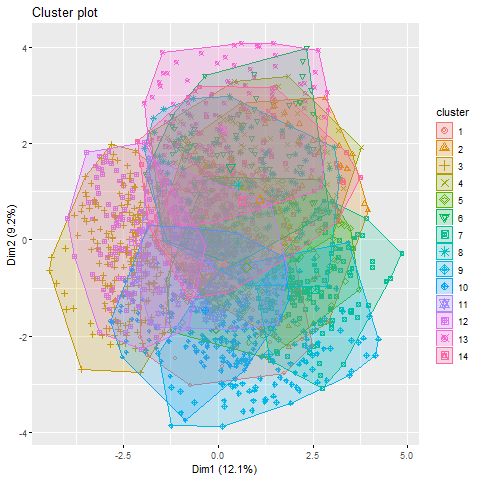

In [22]:
%%R -i r_df
library(factoextra)
fviz_cluster(object=list(data=r_df[lst, c(1:24)], cluster=r_df[lst, c(25)]), geom="point")

<b>Does 14 clusters make sense?</b><br>

On visualizing with 2000 observations, I notice that the clusters are overlapping. Centroids of the 14 clusters are quite close to each other.
 
 There are NO homogenous subgroups among the observations, clusters are not distinct and have similar properties. 
That is the total sum of squares is very high.  It is better to have a different number of clusters. This method finds many very similar overlapping clusters which is of less value in segmentation.

<b>(c)</b> Compare the results from your clustering algorithm to the actual users for the entire dataset. To do this :

(i) calculate the Gini coefficient for each cluster, and also report the average Gini coefficient for the clustering method. For $K$ total labels, the Gini coefficient for each cluster is given by $$1 - \sum_{i=1}^K p_i^2,$$ where $p_i$ is the proportion of data point with label $i$ in the cluster (given that there are also $K$ clusters, e.g., 14 people and 14 clusters). 

(ii) calculate the entropy of each cluster, where entropy is defined as $$-\sum_{i=1}^K p_i \log p_i,$$ and also report the average entropy.

Hint: be careful, because r_stats.kmeans returns cluster numbers beginning with 1.

In [27]:
scaled_df.columns

Index(['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3',
       'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7',
       'Cluster14'],
      dtype='object')

In [28]:
df.columns

Index(['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2',
       'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6',
       'X7', 'Y7', 'Z7'],
      dtype='object')

In [18]:
# df_gini = scaled_df.copy()
scaled_df['Class'] = df['Class']
scaled_df['User'] = df['User']
# dfcopy['Cluster14'] = r_km_out.rx2("cluster")

In [35]:
#count of users in each cluster
gini_coef = []
entropy = []
for i in scaled_df['Cluster14'].unique():
    item_lst = [row['User'] for index, row in scaled_df.iterrows() if row['Cluster14'] == i]
    ctr = collections.Counter(item_lst)
    #compute pi(proportion of data point with label i)
    pgc=1
    pe=1
    count_len=len(item_lst)
    for key, val in ctr.items():
        p = val/count_len
        pgc-=(p**2)
        pe+=(p*math.log(p))
    pe=-1*pe
    gini_coef.append(pgc)
    entropy.append(pe)

In [36]:
#view gini coefficient for each cluster
gini_coef

[0.6217219586491833,
 0.8973103080181125,
 0.8983542352098481,
 0.8891830005471152,
 0.8990083061899281,
 0.8438734699251315,
 0.8742728412440544,
 0.8405349140938646,
 0.8847241995560298,
 0.8201720214266516,
 0.9023244849299457,
 0.8884854833563088,
 0.8245180697700457,
 0.8255190210955662]

In [37]:
#view entropy for each cluster
entropy

[0.33832927028010595,
 1.3913836359231087,
 1.3895359190997791,
 1.3563585183161844,
 1.3883231548356405,
 1.0801565320504443,
 1.2819301063110917,
 1.0943290987798822,
 1.3226731710441353,
 1.0367866014441331,
 1.4101657988666054,
 1.3429144715997052,
 0.9539335452509325,
 0.9504799614486238]

In [38]:
#calculate average gini coefficient and average entropy
avg_gini_coef = sum(gini_coef)/len(gini_coef)
avg_entropy = sum(entropy)/len(entropy)
print("average gini coefficient is:",round(avg_gini_coef,2), "\naverage entropy is:",round(avg_entropy,2))

average gini coefficient is: 0.85 
average entropy is: 1.17


(d) Repeat all of the above steps, but group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means on a random sample of 2,000 observations without replacement (setting 109 as the random seed when sampling), using the function `r_factoextra.fviz_cluster`. Does 5 clusters seem to make sense?

(iii) Calculate the Gini coefficient for each cluster, and also report the average Gini coefficient.

(iv) Calculate the entropy of each cluster, and also report the average entropy. 


In [19]:
#create 5 clusters with k-means algorithm
r_km_out5 = r_stats.kmeans(scaled_df.iloc[:,1:24], centers=5, nstart=46)  #set n_start to 46 and set number of clusters to 14
display(r_km_out5)

R object with classes: ('kmeans',) mapped to:
<ListVector - Python:0x7faa07440e48 / R:0x561c567b92d8>
[IntVector, Matrix, FloatVector, FloatVector, ..., FloatVector, IntVector, IntVector, IntVector]
  cluster: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa06b2b948 / R:0x561c5923f5a0>
[3, 2, 4, 4, ..., 5, 3, 5, 5]
  centers: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7faa0744d608 / R:0x561c541e0ea0>
[0.308703, 0.108437, 0.129117, 0.119986, ..., -0.233884, -1.116157, 0.324390, 0.042805]
  totss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa075d92c8 / R:0x561c5900fb10>
[895689.000000]
  withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa075da988 / R:0x561c56c73e88>
[149107.069438, 132573.442943, 128477.479905, 119608.901033, 187330.794538]
  tot.withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa075dab88 / R:0x561c5901e150>
[717097.687857]
  betweenss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7faa075d6308 / R:0x561c590101a0>
[178591.312143]
  size: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa0788bec8 / R:0x561c56c4fc08>
[9,321, 6,992, 6,910, 6,245, 9,475]
  iter: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa075d6188 / R:0x561c5901df20>
[10]
  ifault: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7faa075d4ec8 / R:0x561c5901de08>
[0]

In [20]:
scaled_df['Cluster5'] = r_km_out5.rx2("cluster")  #add variable Cluster5 to the dataset

In [21]:
scaled_df.columns

Index(['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3',
       'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7',
       'Cluster14', 'Class', 'User', 'Cluster5'],
      dtype='object')

In [29]:
r_df5 = pandas2ri.py2ri(scaled_df)

In [30]:
%%R -i r_df5
set.seed(109)
lst = sample(nrow(r_df5), 2000, replace=FALSE) 
#Random sample of 2000 observations without replacement and with random_seed=109 

In [31]:
r_df5

X0,Y0,Z0,...,Class,User,Cluster5
0.625185,-1.089155,-1.544096,...,1,0,1
1.005453,-0.502856,-1.511933,...,1,0,2
-1.812131,-0.298840,-0.189590,...,1,0,2
0.356992,0.118135,0.861236,...,2,0,5
...,...,...,...,...,...,...
0.086370,0.884419,-0.716476,...,5,14,4
0.080989,0.884809,-0.720964,...,5,14,1


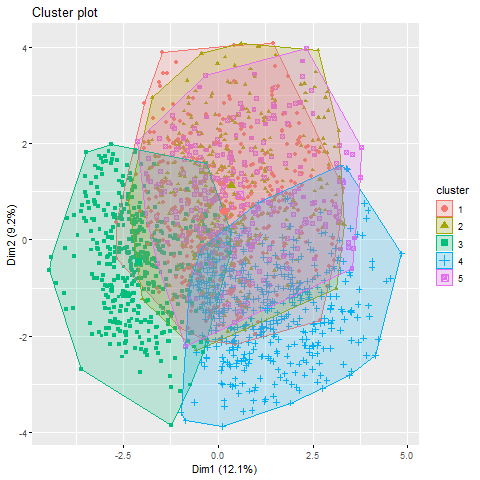

In [33]:
%%R -i r_df5
library(factoextra)
fviz_cluster(object=list(data=r_df5[lst, c(1:24)], cluster=r_df5[lst, c(28)]), geom = "point")
#visualize kmeans results on full dataset

In [35]:
#count of users in each cluster
gini_coef5 = []
entropy5 = []
for i in scaled_df['Cluster5'].unique():
    item_lst = [row['User'] for index, row in scaled_df.iterrows() if row['Cluster5'] == i]
    ctr = collections.Counter(item_lst)
    #compute pi(proportion of data point with label i)
    pgc=1
    pe=1
    count_len=len(item_lst)
    for key, val in ctr.items():
        p = val/count_len
        pgc-=(p**2)
        pe+=(p*math.log(p))
    pe=-1*pe
    gini_coef5.append(pgc)
    entropy5.append(pe)

In [37]:
#view gini coefficient for each cluster
gini_coef5

[0.9037195690676754,
 0.9049127365712295,
 0.9051389117267842,
 0.8643129584805356,
 0.8719958998965553]

In [38]:
#view entropy for each cluster
entropy5

[1.4246971967814246,
 1.438199718702868,
 1.4376672348131754,
 1.1782133817179798,
 1.2374901620977439]

In [36]:
#calculate average gini coefficient and average entropy
avg_gini_coef5 = sum(gini_coef5)/len(gini_coef5)
avg_entropy5 = sum(entropy5)/len(entropy5)
print("average gini coefficient is:",round(avg_gini_coef5,2), "\naverage entropy is:",round(avg_entropy5,2))

average gini coefficient is: 0.89 
average entropy is: 1.34


<b>(e) What do the results suggest? Does this make sense in the context of what we know about the problem?</b>

5 clusters has only a slight improvement in the gini coefficient. It is increases by 0.04 or (2.3% increase). This means that 5 clusters is definitely a better approach than the 14 clusters.
<br><br>
With regard to the problem dataset, since X, Y and Z coordinates are marker positions to capture the postures, it is definitely more appropriate to divide the dataset into 5 clusters for 5 postures. Here, 14 clusters will not be very appropriate.

<div class='exercise'> <b> Problem 2: Clustering Evaluation and Hierarchical Clustering </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate various ways of evaluating the quality of a clustering assignment. For all of these questions, you can work with the sample of 2,000 data points obtained in the previous problem.

Hint: Use the function `r_factoextra.fviz_nbclust`.

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

In [22]:
sdf2000 = scaled_df.sample(n=2000, replace=False, random_state=109)

In [23]:
sdf2000.shape  # view shape of the dataset with 2000 observations

(2000, 28)

In [24]:
r_sdf2000 = pandas2ri.py2ri(sdf2000)

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


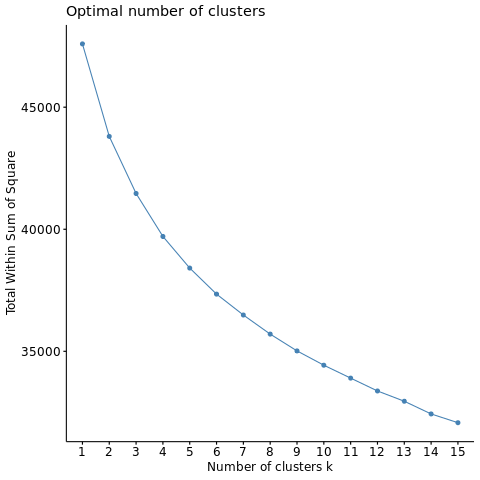

In [25]:
%%R -i r_sdf2000
fviz_nbclust(r_sdf2000[,c(1:24)], kmeans, method="wss", nstart = 46, k.max = 15)

<br>
Elbow plot is shows “percentage of variance explained” on the Y-axis and number of clusters “K” on X-axis. By observing the elbow plot, k=3 or k=4 is the appropriate number of clusters. The first cluster adds much information, but at k=4 the marginal gain starts to drop.

(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

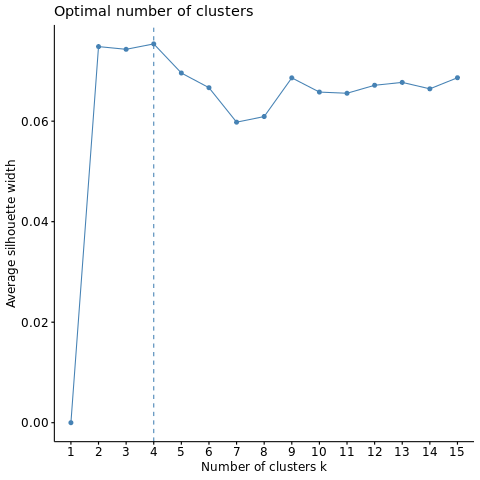

In [26]:
%%R -i r_sdf2000
fviz_nbclust(r_sdf2000[,c(1:24)], kmeans, method="silhouette", nstart = 46, k.max = 15)


<br>
Silhouette plot validates consistency within clusters. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). By observing the silhouette plot, we k=4 is the optimal number of clusters, which has the highest silhouette value.

<b>(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. </b>

Clustering k = 1,2,..., K.max (= 15): .. done
Bootstrapping, b = 1,2,..., B (= 100)  [one "." per sample]:
.................................................. 50 
.................................................. 100 


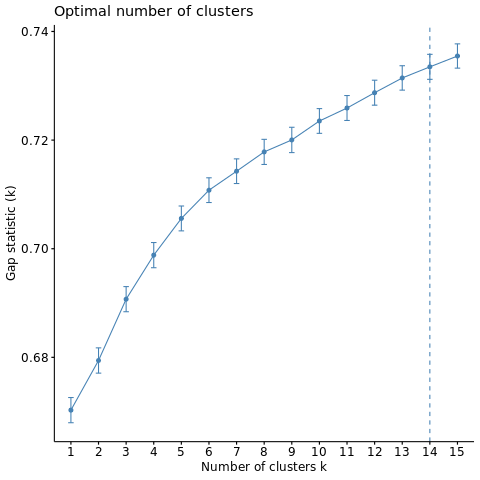

In [32]:
%%R -i r_sdf2000
fviz_nbclust(r_sdf2000[,c(1:24)], kmeans, method="gap", nstart = 46, k.max = 15)


<br>
Gap statistic compares total within cluster variation to the expected within cluster variation under the assumption that data is randomly distributed. Using gap statistic, 8 clusters seems to be the optimal number of clusters. 
<br>
For k=9 the criteria "Gap(k)≥Gap(k+1)−sk+1" is not satified

<b>(d) After analyzing the plots produced by all three of these measures, discuss the number of clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you sumarise about this dataset.</b>


<br>
We received different k values from each of the above plots. From elbow plot I would chose k=4, from silhouette plot it is k=4 and from gap statistic it is k=8. 
<br>
Elbow plot is shows “percentage of variance explained” on the Y-axis. k=4 has the maximum variance explained, after which marginal gain starts to drop. While silhouette plot, measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Gap statistic checks on the criteria "Gap(k)≥Gap(k+1)−sk+1" and k=8 is the optimal number of clusters for this method.

Considering higher dissimilarity between clusters and less intercluster distance, k=4 is seems to be the optimal number of clusters.

<b>(e) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results.</b>

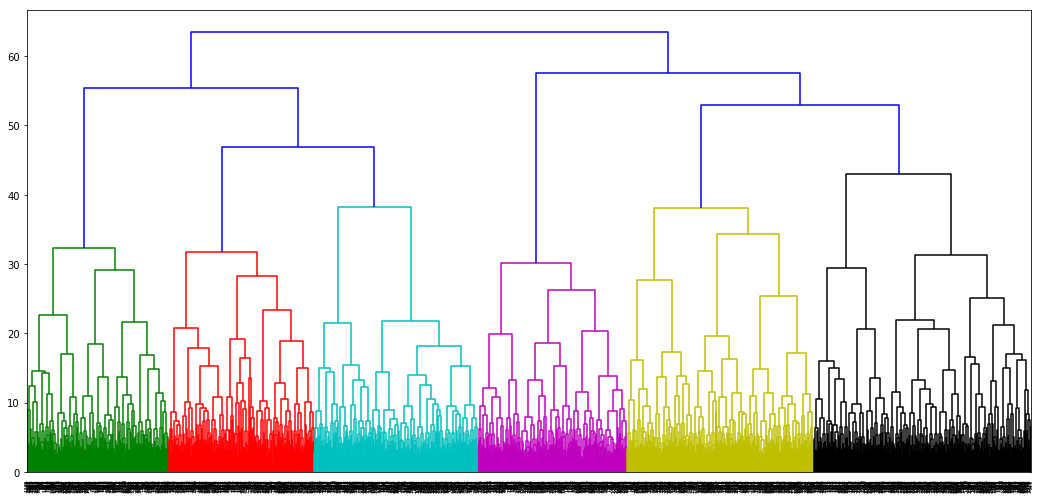

In [59]:
plt.figure(figsize=(18,8.5))
dist_mat = pdist(sdf2000.iloc[:, 1:24], metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data);

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


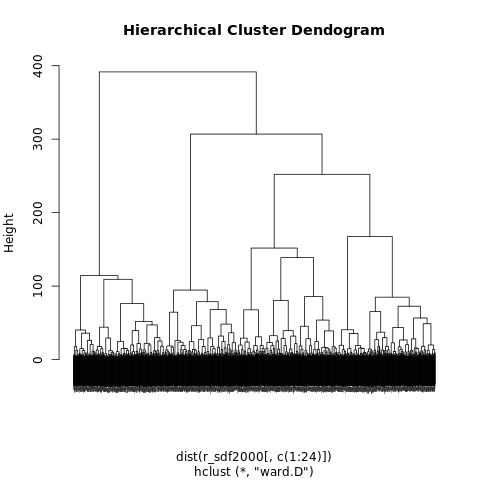

In [60]:
%%R -i r_sdf2000
stacked_cluster = hclust(dist(r_sdf2000[,c(1:24)]), method = "ward.D")
plot(stacked_cluster, cex=.1, main="Hierarchical Cluster Dendogram")

**Solution**
<br>
By observing dendogram, I feel k=6 is the appropriate number of clusters, because dissimilarity between clusters is highest with k=6. Beyond k=6, dissimilarity reduces.